In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import helper_functions as f

2023-07-26 18:41:43.925276: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 18:41:44.781619: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load SIGNALS

In [2]:
wireplane = "V"
np.random.seed(77)

In [3]:
dataset_adc_5_16 = np.load('/home/vlian/Workspace/ar39_new_samples/adc_5_16_V.npz', allow_pickle=True)

In [4]:
adc_5 = dataset_adc_5_16['adc_5']
adc_6 = dataset_adc_5_16['adc_6']
adc_7 = dataset_adc_5_16['adc_7']
adc_8 = dataset_adc_5_16['adc_8']
adc_9 = dataset_adc_5_16['adc_9']
adc_10 = dataset_adc_5_16['adc_10']

In [5]:
def cut_data(adc_group, type_):
    if type_:
        num_samples = 100000
    else:
        num_samples = 60000
    
    x = adc_group[0][0:num_samples]
    y = adc_group[1][0:num_samples]
    
    print(x.shape, y.shape)
    
    return x, y

In [6]:
adc_5_x, adc_5_y = cut_data(adc_5, True)
adc_6_x, adc_6_y = cut_data(adc_6, True)
adc_7_x, adc_7_y = cut_data(adc_7, True)
adc_8_x, adc_8_y = cut_data(adc_8, True)
adc_9_x, adc_9_y = cut_data(adc_9, True)
adc_10_x, adc_10_y = cut_data(adc_10, True)

del adc_5, adc_6, adc_7, adc_8, adc_9, adc_10


(100000, 200) (100000, 200)
(100000, 200) (100000, 200)
(100000, 200) (100000, 200)
(100000, 200) (100000, 200)
(100000, 200) (100000, 200)
(100000, 200) (100000, 200)


In [7]:
x_train = np.empty((0,200))
x_train = np.concatenate((x_train, adc_5_x))
x_train = np.concatenate((x_train, adc_6_x))
x_train = np.concatenate((x_train, adc_7_x))
x_train = np.concatenate((x_train, adc_8_x))
x_train = np.concatenate((x_train, adc_9_x))
x_train = np.concatenate((x_train, adc_10_x))

y_train = np.empty((0,200))
y_train = np.concatenate((y_train, adc_5_y))
y_train = np.concatenate((y_train, adc_6_y))
y_train = np.concatenate((y_train, adc_7_y))
y_train = np.concatenate((y_train, adc_8_y))
y_train = np.concatenate((y_train, adc_9_y))
y_train = np.concatenate((y_train, adc_10_y))

In [8]:
print(x_train.shape, y_train.shape)

(600000, 200) (600000, 200)


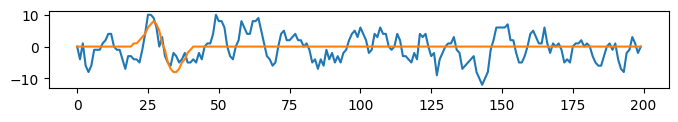

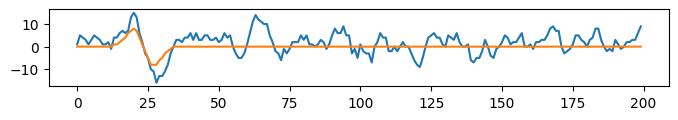

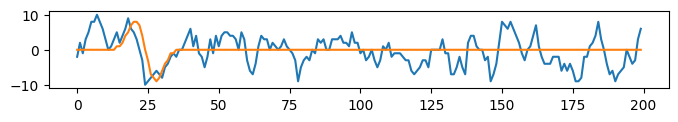

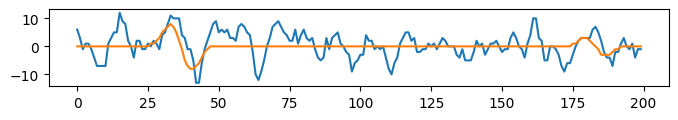

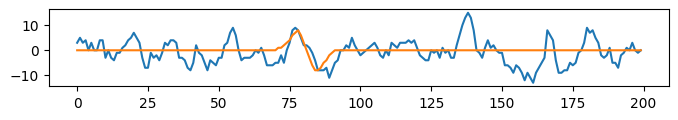

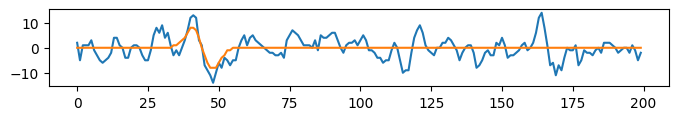

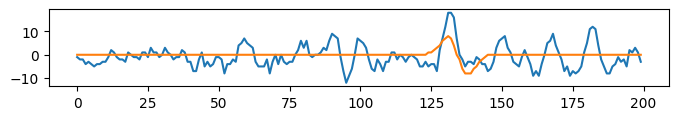

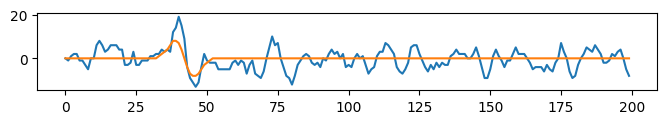

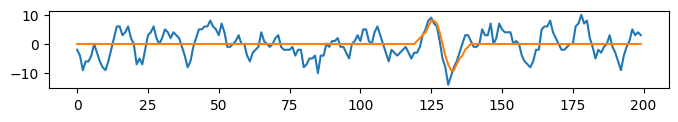

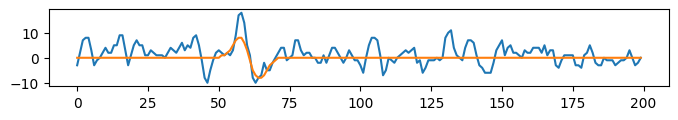

In [9]:
for i in range(300000,300000+10):
    fig = plt.figure(figsize=(8,1))
    plt.plot(x_train[i])
    plt.plot(y_train[i])
    plt.show()

In [10]:
for i in range(100):
    x_train, y_train = shuffle(x_train, y_train)

In [11]:
print(x_train.shape, y_train.shape)

(600000, 200) (600000, 200)


In [12]:
roi_truth_signals = np.ones(y_train.shape[0])

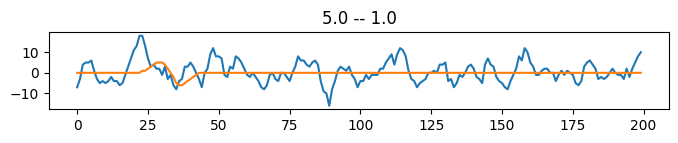

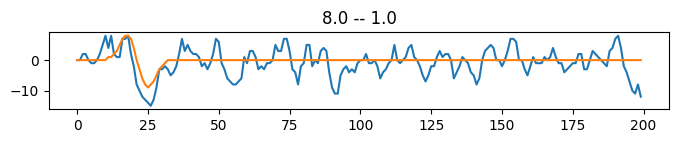

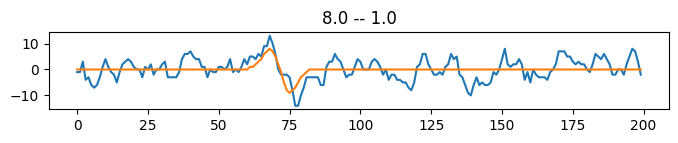

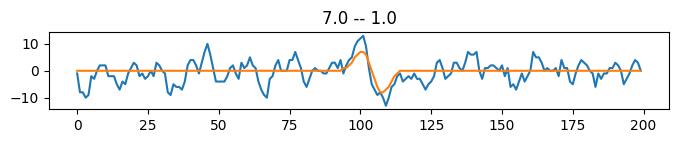

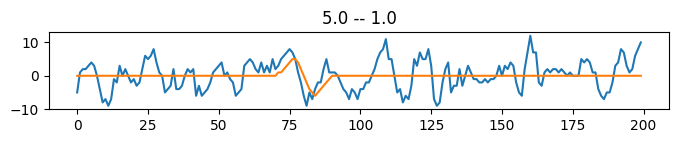

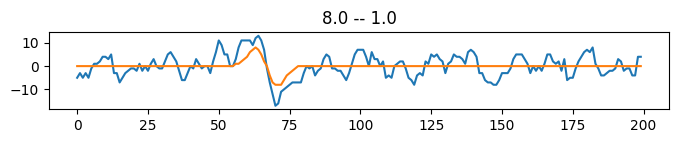

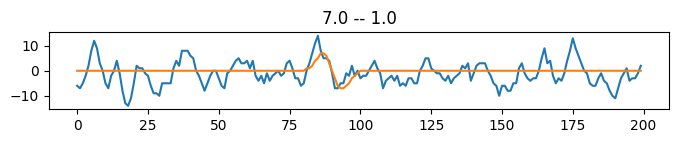

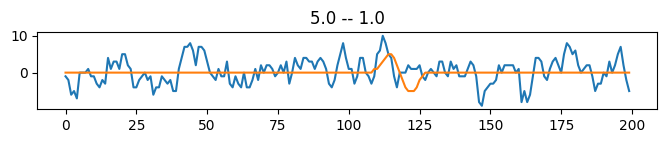

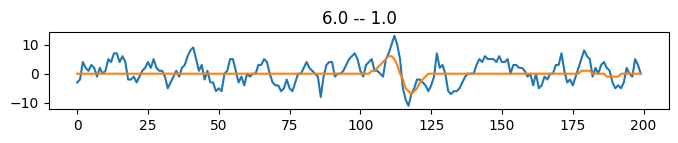

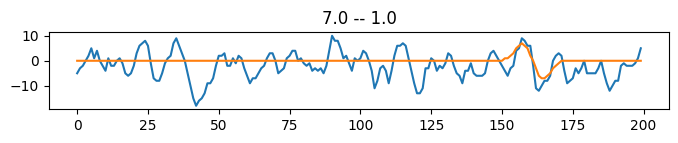

In [13]:
for i in range(10):
    fig = plt.figure(figsize=(8,1))
    plt.title(str(max(y_train[i])) + ' -- ' + str(roi_truth_signals[i]) )
    plt.plot(x_train[i])
    plt.plot(y_train[i])
    plt.show()

In [14]:
check_grouping = f.adc_grouping(x_train, y_train)
del check_grouping

 0: adc_5_7             1: adc_8_10             2: adc_11_13             3: adc_14_16             4: adc_17_19             5: adc_20_22             6: adc_gt_22           

adc_5_7
count       300000

adc_8_10
count       300000

adc_11_13
count       0

adc_14_16
count       0

adc_17_19
count       0

adc_20_22
count       0

adc_gt_22
count       0

     Total:    600000


## Load NOISE

In [15]:
noise_path = '/home/vlian/Workspace/more-noise/V/'
noise_filenames = sorted([f for f in listdir(noise_path) if (isfile(join(noise_path, f)) and wireplane in f)])
combined_noise = np.concatenate([np.load(noise_path+fname, mmap_mode='r') for fname in noise_filenames])

noise_waveforms = f.get_std_waveforms(combined_noise, 200)
noiseless_waveform = noise_waveforms*0 # for autoencoder
roi_truth_noise = np.zeros(noise_waveforms.shape[0]) # for roi finder
print(noise_waveforms.shape, roi_truth_noise.shape)

(1400000, 200) (1400000,)


In [16]:
for i in range(10):
    noise_waveforms = shuffle(noise_waveforms)

In [17]:
noise_waveforms = noise_waveforms[:y_train.shape[0]]
noiseless_waveform = noiseless_waveform[:y_train.shape[0]]
roi_truth_noise = roi_truth_noise[:y_train.shape[0]]

In [18]:
print(noise_waveforms.shape, noiseless_waveform.shape, roi_truth_noise.shape)

(600000, 200) (600000, 200) (600000,)


## Train/Test Split - Signals

In [19]:
x_train, x_test, y_train_ROI, y_test_ROI, y_train_AE, y_test_AE = train_test_split(x_train, roi_truth_signals, y_train, test_size=0.5, shuffle=True)
print(x_train.shape, x_test.shape, y_train_ROI.shape, y_train_AE.shape, y_test_ROI.shape, y_test_AE.shape)

(300000, 200) (300000, 200) (300000,) (300000, 200) (300000,) (300000, 200)


#### Train/Val Split - Signals

In [20]:
x_train, x_valid, y_train_ROI, y_valid_ROI, y_train_AE, y_valid_AE = train_test_split(x_train, y_train_ROI, y_train_AE, test_size=0.2, shuffle=True)
print(x_train.shape, x_valid.shape, y_train_ROI.shape, y_train_AE.shape, y_valid_ROI.shape, y_valid_AE.shape)

(240000, 200) (60000, 200) (240000,) (240000, 200) (60000,) (60000, 200)


## Train/Test Split - Noise

In [21]:
x_noise_train, x_noise_test, y_noise_train_ROI, y_noise_test_ROI, y_noise_train_AE, y_noise_test_AE = train_test_split(noise_waveforms, 
                                                                                                     roi_truth_noise, noiseless_waveform, test_size=0.5, shuffle=True)
print(x_noise_train.shape, x_noise_test.shape, y_noise_train_ROI.shape, y_noise_train_AE.shape, y_noise_test_ROI.shape, y_noise_test_AE.shape)

(300000, 200) (300000, 200) (300000,) (300000, 200) (300000,) (300000, 200)


#### Train/Val Split - Noise

In [22]:
x_noise_train, x_noise_valid, y_noise_train_ROI, y_noise_valid_ROI, y_noise_train_AE, y_noise_valid_AE = train_test_split(x_noise_train, 
                                                                                                        y_noise_train_ROI, y_noise_train_AE,
                                                                                                        test_size=0.2, shuffle=True)
print(x_noise_train.shape, x_noise_valid.shape, y_noise_train_ROI.shape, y_noise_train_AE.shape, y_noise_valid_ROI.shape, y_noise_valid_AE.shape)

(240000, 200) (60000, 200) (240000,) (240000, 200) (60000,) (60000, 200)


## Combine Signal + Noise

In [23]:
x_train = np.concatenate((x_train, x_noise_train))
y_train_ROI = np.concatenate((y_train_ROI, y_noise_train_ROI))
y_train_AE = np.concatenate((y_train_AE, y_noise_train_AE))

x_valid = np.concatenate((x_valid, x_noise_valid))
y_valid_ROI = np.concatenate((y_valid_ROI, y_noise_valid_ROI))
y_valid_AE = np.concatenate((y_valid_AE, y_noise_valid_AE))

x_test = np.concatenate((x_test, x_noise_test))
y_test_ROI = np.concatenate((y_test_ROI, y_noise_test_ROI))
y_test_AE = np.concatenate((y_test_AE, y_noise_test_AE))

print(x_train.shape, y_train_ROI.shape, y_train_AE.shape)
print(x_valid.shape, y_valid_ROI.shape, y_valid_AE.shape)
print(x_test.shape, y_test_AE.shape, y_test_ROI.shape)

(480000, 200) (480000,) (480000, 200)
(120000, 200) (120000,) (120000, 200)
(600000, 200) (600000, 200) (600000,)


In [24]:
for i in range(100):
    x_train, y_train_ROI, y_train_AE = shuffle(x_train, y_train_ROI, y_train_AE)
    x_valid, y_valid_ROI, y_valid_AE = shuffle(x_valid, y_valid_ROI, y_valid_AE)
    x_test, y_test_ROI, y_test_AE = shuffle(x_test, y_test_ROI, y_test_AE)

In [25]:
print(x_train.shape, y_train_ROI.shape, y_train_AE.shape)
print(x_valid.shape, y_valid_ROI.shape, y_valid_AE.shape)
print(x_test.shape, y_test_AE.shape, y_test_ROI.shape)

(480000, 200) (480000,) (480000, 200)
(120000, 200) (120000,) (120000, 200)
(600000, 200) (600000, 200) (600000,)


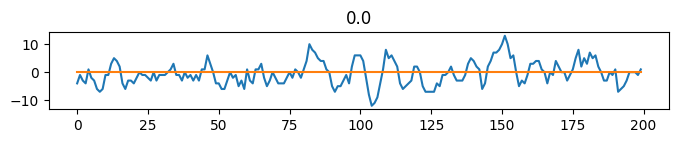

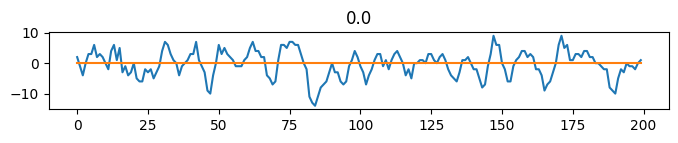

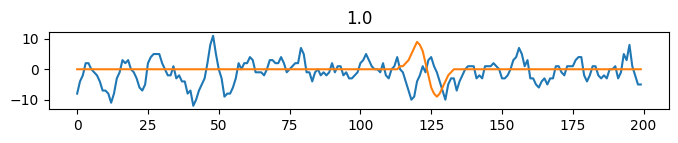

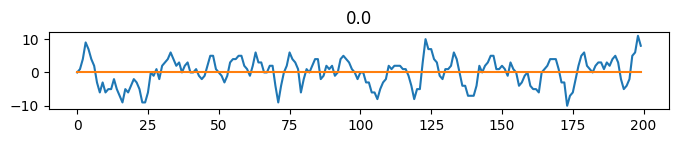

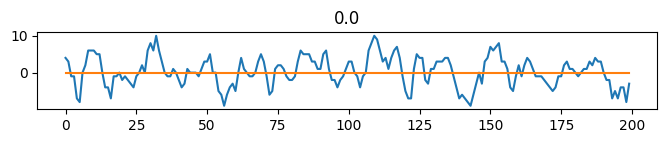

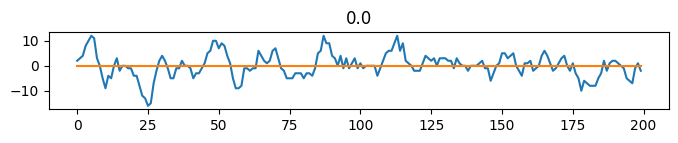

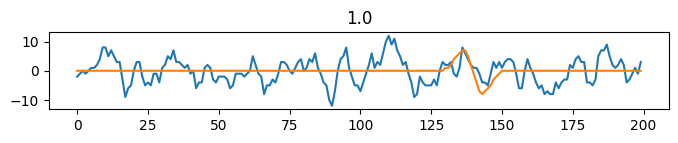

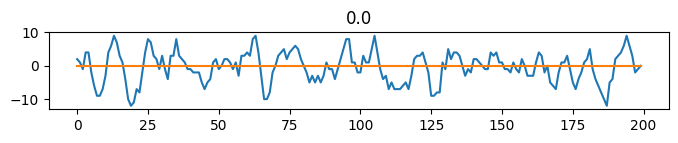

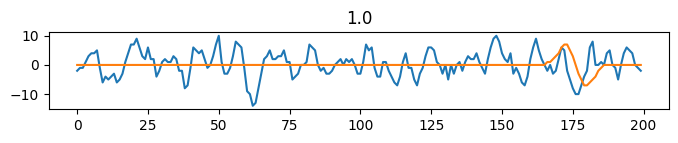

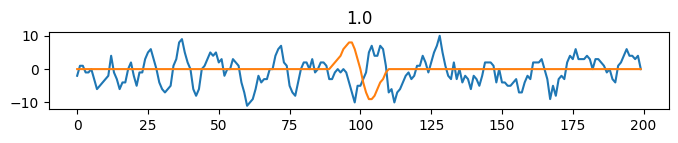

In [26]:
for i in range(10):
    fig = plt.figure(figsize=(8,1))
    plt.title(y_train_ROI[i])
    plt.plot(x_valid[i])
    plt.plot(y_train_AE[i])
    plt.show()
    

In [27]:
mean = x_train.mean()
std = x_train.std()

In [28]:
print(mean, std)

0.009963520833333333 4.532821219441512


In [29]:
np.save("models_scales/mean_5_10"+wireplane+"_nu", mean)
np.save("models_scales/scale_5_10"+wireplane+"_nu", std)

In [30]:
x_train_scaled = (x_train-mean)/std
y_train_AE_scaled = (y_train_AE-mean)/std

x_valid_scaled = (x_valid-mean)/std
y_valid_AE_scaled = (y_valid_AE-mean)/std

x_test_scaled = (x_test-mean)/std
y_test_AE_scaled = (y_test_AE-mean)/std

In [31]:
x_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
x_valid_scaled = x_valid_scaled.reshape(x_valid_scaled.shape[0], x_valid_scaled.shape[1], 1)
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

In [32]:
print(x_train_scaled.shape, x_valid_scaled.shape, x_test_scaled.shape)

(480000, 200, 1) (120000, 200, 1) (600000, 200, 1)


# MODEL - ROI

In [33]:
#!pip install keras-tuner --upgrade

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, \
    Dropout, Dense,Flatten, AveragePooling1D, BatchNormalization

In [35]:
time_periods = 200
def create_model():
    model = Sequential()  
    #first convolutional block
    model.add(Conv1D(filters=16, kernel_size=3, strides=2, activation = "relu", input_shape=(time_periods,1)))
    model.add(MaxPooling1D(pool_size=2))

    #second convolutional block
    model.add(Conv1D(filters=32, kernel_size=5, strides=2, activation = "relu"))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))

    #forth convolutional block                                      
    model.add(Conv1D(filters=64, kernel_size=9, activation = "relu"))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.2)) 

    model.add(Flatten())



    model.add(Dense(1, activation="sigmoid", name="wavrec_out"))
    return model

In [36]:
model_ROI = create_model()

#lr=0.001
adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_ROI.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
model_ROI.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 99, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 32)            2592      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 11, 32)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 64)             1

2023-07-26 18:44:49.080873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 18:44:49.117681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 18:44:49.118080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [37]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [38]:
#%%time
history = model_ROI.fit(x_train_scaled,                                                              
                    y_train_ROI,
                    batch_size = 512,
                    epochs=100,      
                   # epochs=30, 
                    #epochs = 6,
                    callbacks=[earlystop],
                     # callbacks=callbacks_list,                         
                    validation_data=(x_valid_scaled, y_valid_ROI),                                               
                    verbose=1)   

Epoch 1/100


2023-07-26 18:44:52.329262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-26 18:44:53.495620: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


938/938 [==============================] - 8s 5ms/step - loss: 0.5531 - accuracy: 0.7102 - val_loss: 0.5221 - val_accuracy: 0.7371
Epoch 2/100
938/938 [==============================] - 4s 5ms/step - loss: 0.5255 - accuracy: 0.7350 - val_loss: 0.5184 - val_accuracy: 0.7390
Epoch 3/100
938/938 [==============================] - 4s 4ms/step - loss: 0.5223 - accuracy: 0.7366 - val_loss: 0.5187 - val_accuracy: 0.7387
Epoch 4/100
938/938 [==============================] - 4s 4ms/step - loss: 0.5211 - accuracy: 0.7371 - val_loss: 0.5168 - val_accuracy: 0.7400
Epoch 5/100
938/938 [==============================] - 4s 4ms/step - loss: 0.5198 - accuracy: 0.7381 - val_loss: 0.5202 - val_accuracy: 0.7366
Epoch 6/100
938/938 [==============================] - 4s 4ms/step - loss: 0.5191 - accuracy: 0.7382 - val_loss: 0.5190 - val_accuracy: 0.7386
Epoch 7/100
938/938 [==============================] - 4s 4ms/step - loss: 0.5184 - accuracy: 0.7388 - val_loss: 0.5183 - val_accuracy: 0.7398
Epoch 8/100

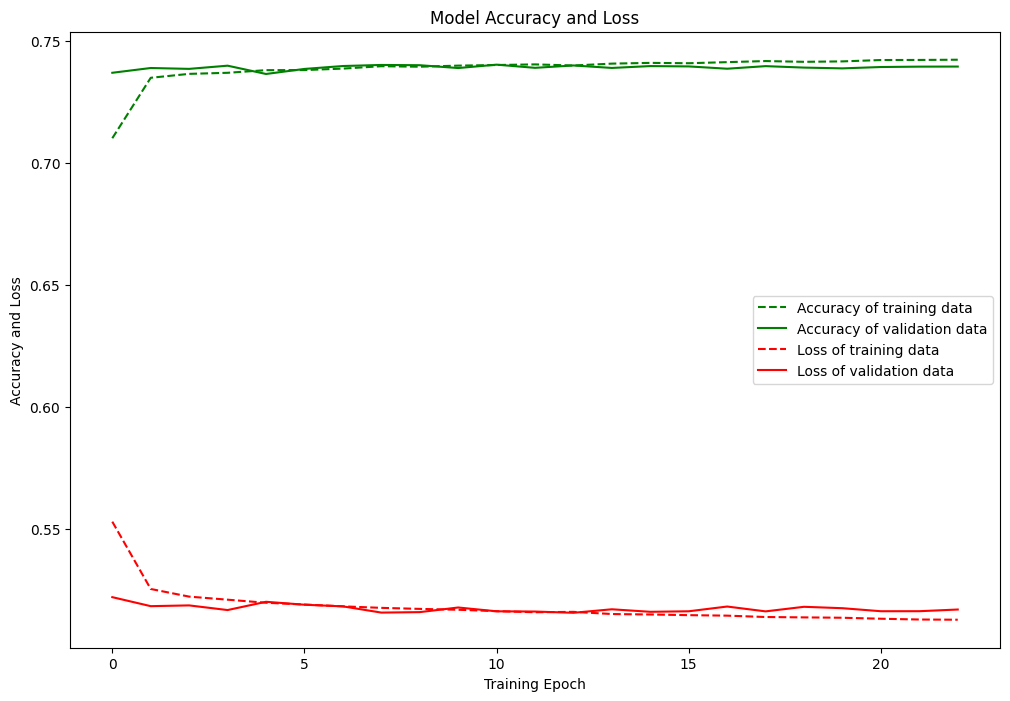

In [39]:
plt.figure(figsize=(12, 8))                                                     
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data", antialiased=True)
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data", antialiased=True)
plt.plot(history.history['loss'], "r--", label="Loss of training data", antialiased=True)
plt.plot(history.history['val_loss'], "r", label="Loss of validation data", antialiased=True)
plt.title('Model Accuracy and Loss')                                            
plt.ylabel('Accuracy and Loss')                                                 
plt.xlabel('Training Epoch')                                                    
#plt.ylim(0)                                                                     
plt.legend()                                                                    
plt.show()     

In [40]:
#HERE

import gc
gc.collect()

22235

In [41]:
model_ROI.save("ROI_ar39_models/model_5_10" + wireplane + "plane_nu_ROI.h5")

In [42]:
model_ROI.evaluate(x_test_scaled, y_test_ROI, batch_size=4096)

147/147 [==============================] - 1s 5ms/step - loss: 0.5176 - accuracy: 0.7378


[0.5176360011100769, 0.7378066778182983]

In [43]:
x_train_ = x_train_scaled
y_train_ = y_train_ROI

x_valid_ = x_valid_scaled
y_valid_ = y_valid_ROI


# test

In [44]:
#%%time
all_infer = model_ROI.predict(x_test_scaled, batch_size=4096)
all_y_test = y_test_ROI


147/147 [==============================] - 0s 2ms/step


In [45]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

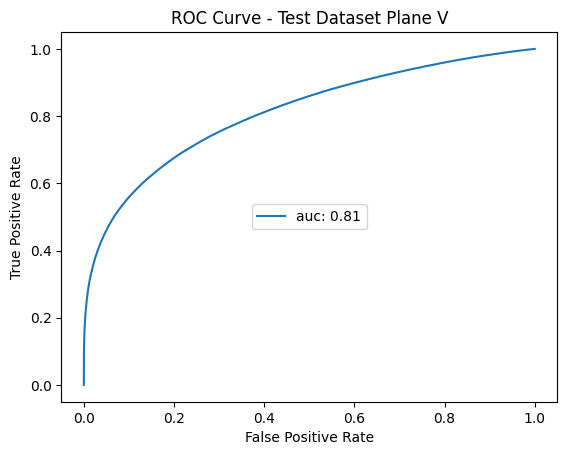

In [46]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(all_y_test, all_infer)
plt.plot(fpr_keras, tpr_keras, label='auc: ' + str(round(auc(fpr_keras, tpr_keras), 3)))
plt.title("ROC Curve - Test Dataset Plane " + wireplane )
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='center')
plt.show()

In [47]:
%%time
#cc_infer_signal = model.predict(cc_x_test_scaled[cc_y_test==1], batch_size=4096)
#cc_infer_noise = model.predict(cc_x_test_scaled[cc_y_test==0], batch_size=4096)
#es_infer_signal = model.predict(es_x_test_scaled[es_y_test==1], batch_size=4096)
#es_infer_noise = model.predict(es_x_test_scaled[es_y_test==0], batch_size=4096)
all_infer_signal = model_ROI.predict(x_test_scaled[y_test_ROI==1], batch_size=4096)
all_infer_noise = model_ROI.predict(x_test_scaled[y_test_ROI==0], batch_size=4096)

74/74 [==============================] - 0s 3ms/step
CPU times: user 1.16 s, sys: 732 ms, total: 1.89 s
Wall time: 1.5 s


(array([0.0000e+00, 1.3000e+01, 1.0073e+04, 4.5533e+04, 5.1767e+04,
        4.4510e+04, 3.4668e+04, 2.6428e+04, 2.0239e+04, 1.5300e+04,
        1.1998e+04, 9.3270e+03, 7.3640e+03, 5.9180e+03, 4.6170e+03,
        3.8360e+03, 3.0700e+03, 2.5100e+03, 1.8080e+03, 1.0210e+03]),
 array([0.        , 0.05      , 0.1       , 0.15000001, 0.2       ,
        0.25      , 0.30000001, 0.34999999, 0.40000001, 0.44999999,
        0.5       , 0.55000001, 0.60000002, 0.64999998, 0.69999999,
        0.75      , 0.80000001, 0.85000002, 0.89999998, 0.94999999,
        1.        ]),
 <BarContainer object of 20 artists>)

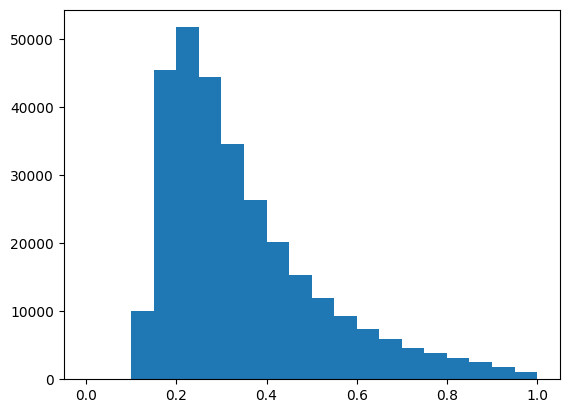

In [48]:
plt.hist(all_infer_noise, range = (0,1), bins=20)

(array([    0.,     0.,  1555.,  9437., 15016., 16885., 17063., 15983.,
        15439., 14469., 13502., 12805., 12461., 12489., 12741., 13321.,
        14604., 17248., 23109., 61873.]),
 array([0.        , 0.05      , 0.1       , 0.15000001, 0.2       ,
        0.25      , 0.30000001, 0.34999999, 0.40000001, 0.44999999,
        0.5       , 0.55000001, 0.60000002, 0.64999998, 0.69999999,
        0.75      , 0.80000001, 0.85000002, 0.89999998, 0.94999999,
        1.        ]),
 <BarContainer object of 20 artists>)

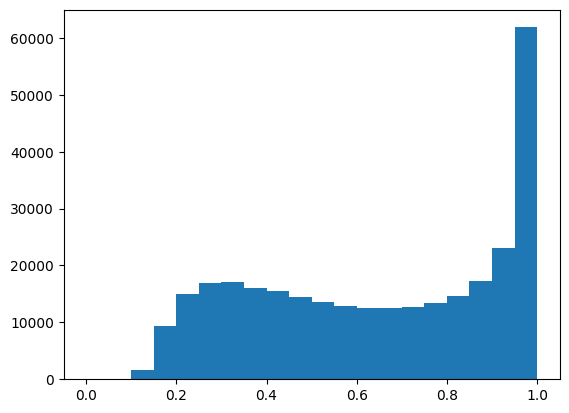

In [49]:
plt.hist(all_infer_signal, range = (0,1), bins=20)

In [50]:
a = [out for out in all_infer if out >= 0.94]

In [51]:
len(a)/len(all_infer)

0.11423

In [52]:
all_infer

array([[0.24042277],
       [0.34534281],
       [0.23750979],
       ...,
       [0.1473618 ],
       [0.40109536],
       [0.25765786]], dtype=float32)

In [53]:
sigs_truth = []
sigs_pred = []

noise_truth = []
noise_pred = []

for i, truth in enumerate(all_y_test):
    if truth == 1:
        sigs_truth.append(truth)
        sigs_pred.append(all_infer[i])
    else:
        noise_truth.append(truth)
        noise_pred.append(all_infer[i])


In [54]:
print(len(sigs_truth), len(sigs_pred))
print(len(noise_truth), len(noise_pred))

300000 300000
300000 300000


In [55]:
a = [out for out in sigs_pred if out >= 0.94]

In [56]:
len(a)/len(sigs_truth)

0.22401

In [57]:
a = [out for out in noise_pred if out < 0.94]

In [58]:
len(a)/len(noise_truth)

0.99555

# MODEL - AE

In [59]:
from tensorflow.keras.layers import Conv1DTranspose

In [60]:
time_periods = 200
autoencoder = Sequential()
# encoder
autoencoder.add(Conv1D(filters=16, kernel_size=3, padding="same", strides=2, activation = "relu", input_shape=(time_periods,1)))
autoencoder.add(Conv1D(filters=32, kernel_size=5, padding="same", strides=4, activation = "relu"))
autoencoder.add(Conv1D(filters=64, kernel_size=9, padding="same", strides=5, activation = "relu"))

# decoder
autoencoder.add(Conv1DTranspose(filters=64, kernel_size=9, padding="same", strides=5, activation = "relu"))
autoencoder.add(Conv1DTranspose(filters=32, kernel_size=5, padding="same", strides=4, activation = "relu"))
autoencoder.add(Conv1DTranspose(filters=16, kernel_size=3, padding="same", strides=2, activation = "relu"))

autoencoder.add(Conv1DTranspose(filters=1, kernel_size=3, padding="same"))

autoencoder.compile(loss='mse', optimizer='adam')

In [61]:
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 100, 16)           64        
                                                                 
 conv1d_4 (Conv1D)           (None, 25, 32)            2592      
                                                                 
 conv1d_5 (Conv1D)           (None, 5, 64)             18496     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 25, 64)           36928     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 32)          10272     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 200, 16)         

In [62]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [63]:
history_AE = autoencoder.fit(x_train_scaled,                                                              
            y_train_AE_scaled,                                                            
            batch_size=512,                                              
            epochs=1000,                                                      
            callbacks= [earlystop], #[NewCallback(alpha)], # callbacks=callbacks_list,
            validation_data=(x_valid_scaled, y_valid_AE_scaled),                                                                      
            verbose=1)

Epoch 1/1000


2023-07-26 18:46:41.239322: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f8aa0723130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-26 18:46:41.239401: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 2g.20gb, Compute Capability 8.0
2023-07-26 18:46:41.248546: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-26 18:46:41.828890: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


938/938 [==============================] - 14s 8ms/step - loss: 0.0360 - val_loss: 0.0338
Epoch 2/1000
938/938 [==============================] - 6s 6ms/step - loss: 0.0336 - val_loss: 0.0335
Epoch 3/1000
938/938 [==============================] - 6s 6ms/step - loss: 0.0334 - val_loss: 0.0336
Epoch 4/1000
938/938 [==============================] - 6s 7ms/step - loss: 0.0333 - val_loss: 0.0333
Epoch 5/1000
938/938 [==============================] - 6s 7ms/step - loss: 0.0332 - val_loss: 0.0333
Epoch 6/1000
938/938 [==============================] - 6s 6ms/step - loss: 0.0332 - val_loss: 0.0334
Epoch 7/1000
938/938 [==============================] - 6s 7ms/step - loss: 0.0331 - val_loss: 0.0334
Epoch 8/1000
938/938 [==============================] - 6s 7ms/step - loss: 0.0331 - val_loss: 0.0333
Epoch 9/1000
938/938 [==============================] - 6s 7ms/step - loss: 0.0330 - val_loss: 0.0333
Epoch 10/1000
938/938 [==============================] - 7s 7ms/step - loss: 0.0330 - val_loss

In [64]:
predictions = autoencoder.predict(x_test_scaled, batch_size=4096)
predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])

147/147 [==============================] - 3s 14ms/step


1/1 [==============================] - 0s 20ms/step
(1, 200, 1)
1/1 [==============================] - 0s 161ms/step
(1, 200, 1)


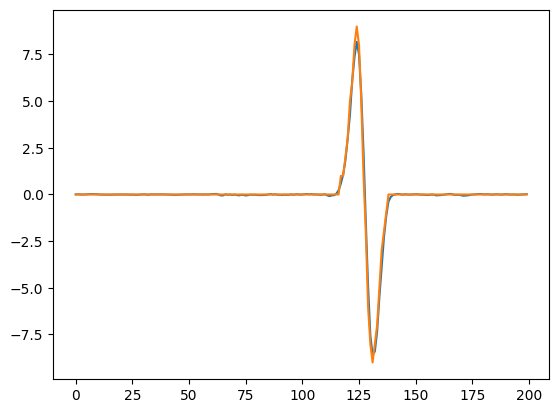

1/1 [==============================] - 0s 20ms/step
(1, 200, 1)
1/1 [==============================] - 0s 19ms/step
(1, 200, 1)


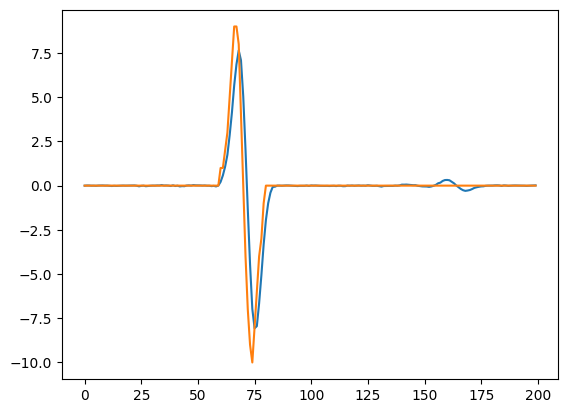

1/1 [==============================] - 0s 19ms/step
(1, 200, 1)
1/1 [==============================] - 0s 19ms/step
(1, 200, 1)


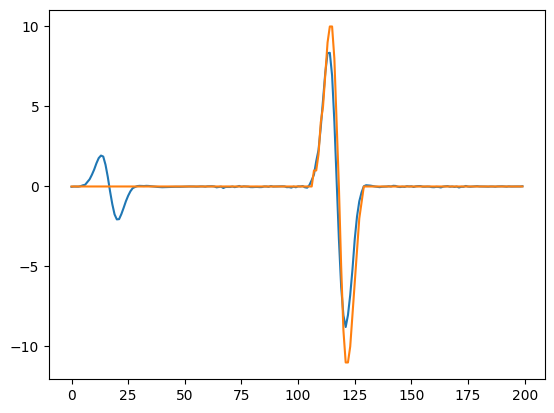

1/1 [==============================] - 0s 20ms/step
(1, 200, 1)
1/1 [==============================] - 0s 20ms/step
(1, 200, 1)


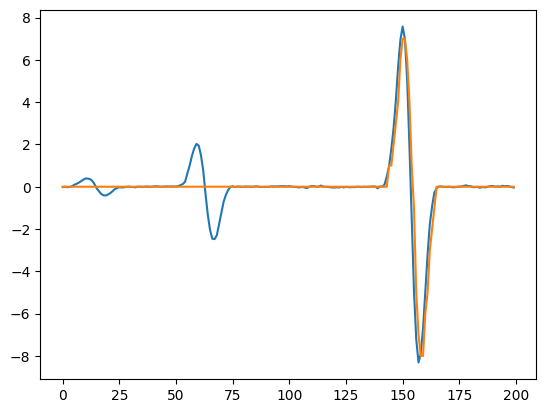

1/1 [==============================] - 0s 20ms/step
(1, 200, 1)
1/1 [==============================] - 0s 21ms/step
(1, 200, 1)


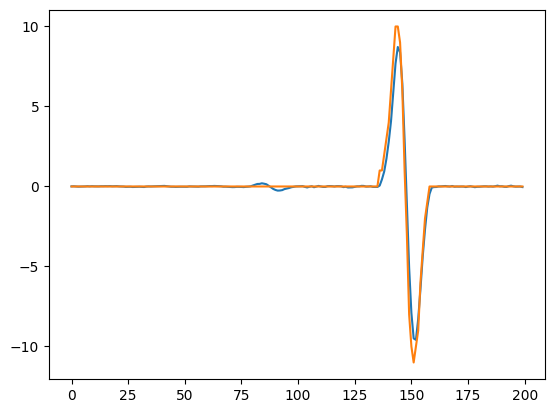

1/1 [==============================] - 0s 20ms/step
(1, 200, 1)
1/1 [==============================] - 0s 22ms/step
(1, 200, 1)


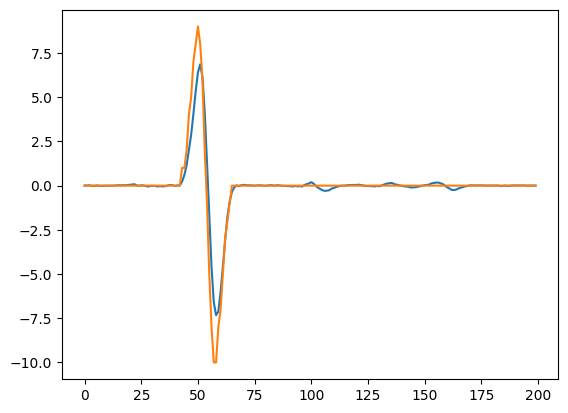

1/1 [==============================] - 0s 21ms/step
(1, 200, 1)
1/1 [==============================] - 0s 18ms/step
(1, 200, 1)


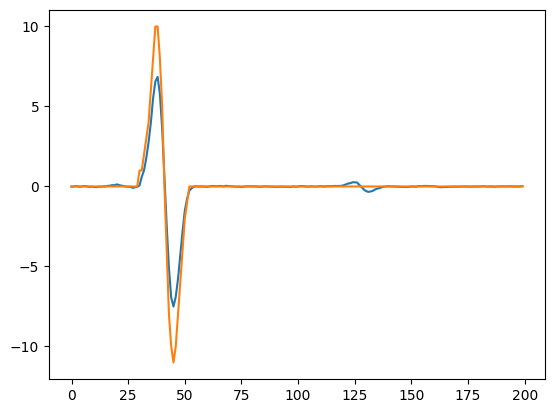

1/1 [==============================] - 0s 19ms/step
(1, 200, 1)
1/1 [==============================] - 0s 20ms/step
(1, 200, 1)


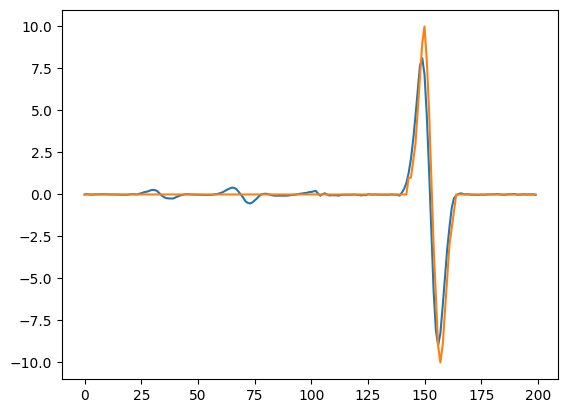

1/1 [==============================] - 0s 22ms/step
(1, 200, 1)
1/1 [==============================] - 0s 19ms/step
(1, 200, 1)


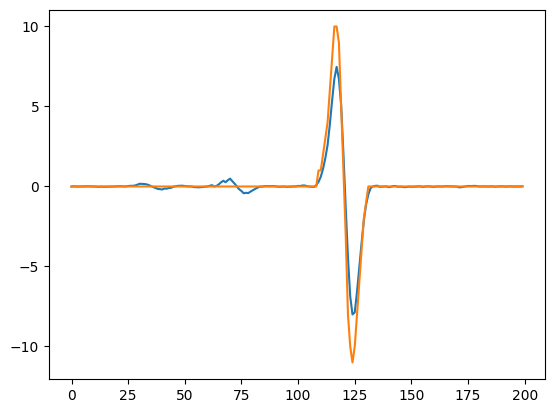

1/1 [==============================] - 0s 19ms/step
(1, 200, 1)
1/1 [==============================] - 0s 26ms/step
(1, 200, 1)


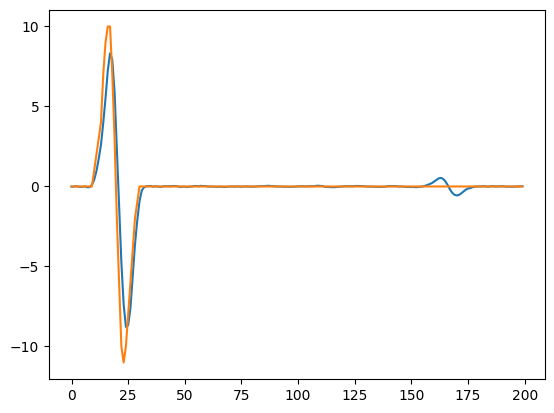

1/1 [==============================] - 0s 130ms/step
(1, 200, 1)
1/1 [==============================] - 0s 19ms/step
(1, 200, 1)


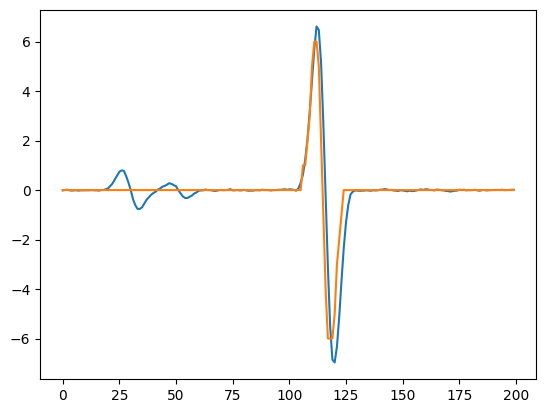

1/1 [==============================] - 0s 19ms/step
(1, 200, 1)
1/1 [==============================] - 0s 20ms/step
(1, 200, 1)


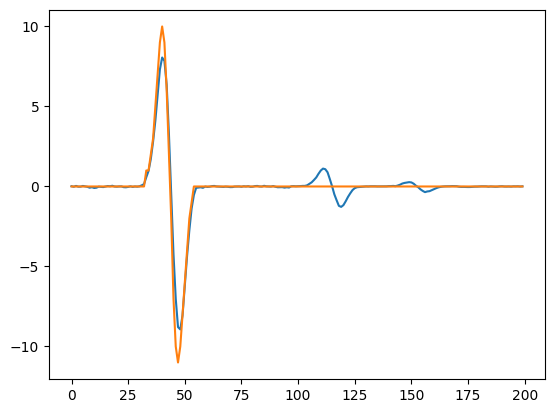

1/1 [==============================] - 0s 25ms/step
(1, 200, 1)
1/1 [==============================] - 0s 19ms/step
(1, 200, 1)


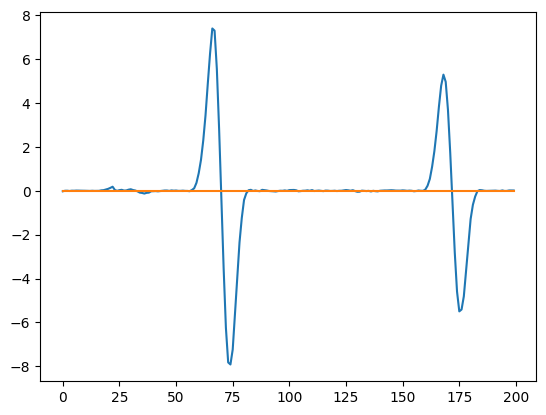

1/1 [==============================] - 0s 23ms/step
(1, 200, 1)
1/1 [==============================] - 0s 19ms/step
(1, 200, 1)


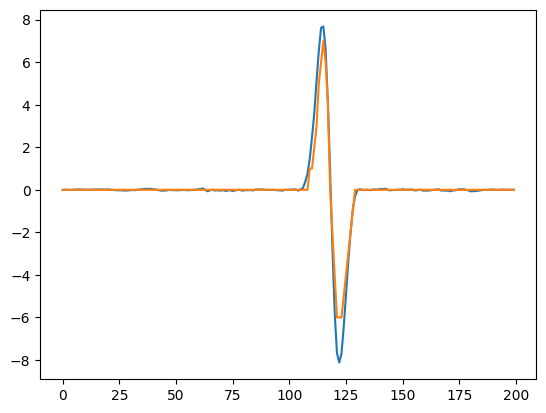

1/1 [==============================] - 0s 19ms/step
(1, 200, 1)
1/1 [==============================] - 0s 19ms/step
(1, 200, 1)


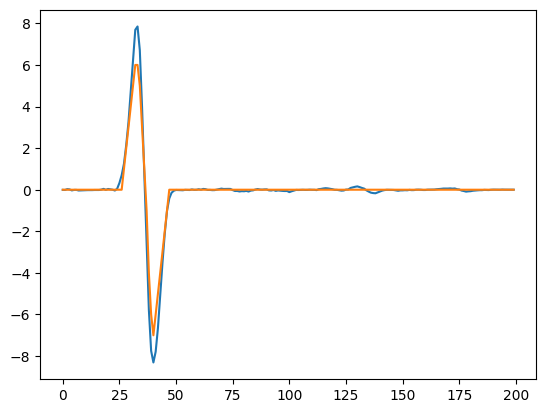

1/1 [==============================] - 0s 17ms/step
(1, 200, 1)
1/1 [==============================] - 0s 19ms/step
(1, 200, 1)


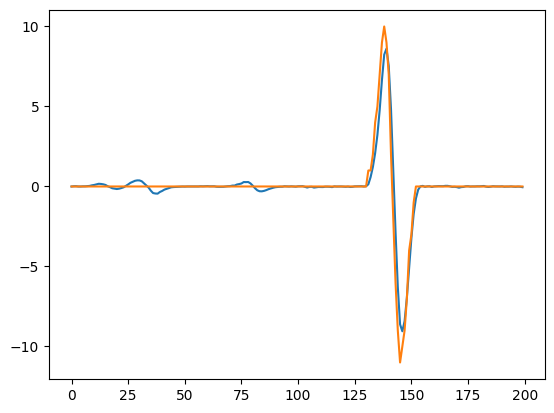

1/1 [==============================] - 0s 17ms/step


In [65]:
for i in range(100):
    wave = x_test_scaled[i:i+1]
    if model_ROI.predict(wave) >= 0.94:
        print(wave.shape)
        ae_pred = autoencoder.predict(wave)
        print(ae_pred.shape)
        pred = ae_pred*std + mean
        
        #wave_re_scaled = wave*std + mean
    
        plt.plot(pred[0])
        plt.plot(y_test_AE[i])
        plt.show()
    

In [66]:
autoencoder.save("AE_ar39_models/model_5_10" + wireplane + "plane_nu_AE.h5")